In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

import pickle

%matplotlib inline 

In [3]:
# tssa model
from src.ssa_methods.t_ssa import t_SSA

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
import src.data.electricity as electricity_data

# partition finding algorithms
from src.ssa_methods.ssa_complementary.ssa_multidim_partition import NextDichotomyPartition

## Data preprocessing

In [4]:
# names of observed signals
sig_names = ['Production program', 'Price']
# measure units
sig_units = ['MhW', 'TL']

num_signals = 2

In [5]:
# retrive signals and corresponding time grids
# they are already preproccessed
(train_data, time_grid_train), (test_data, time_grid_test) = electricity_data.GetTrainTestData(
    series_len=3000,
    test_ratio=0.18
)

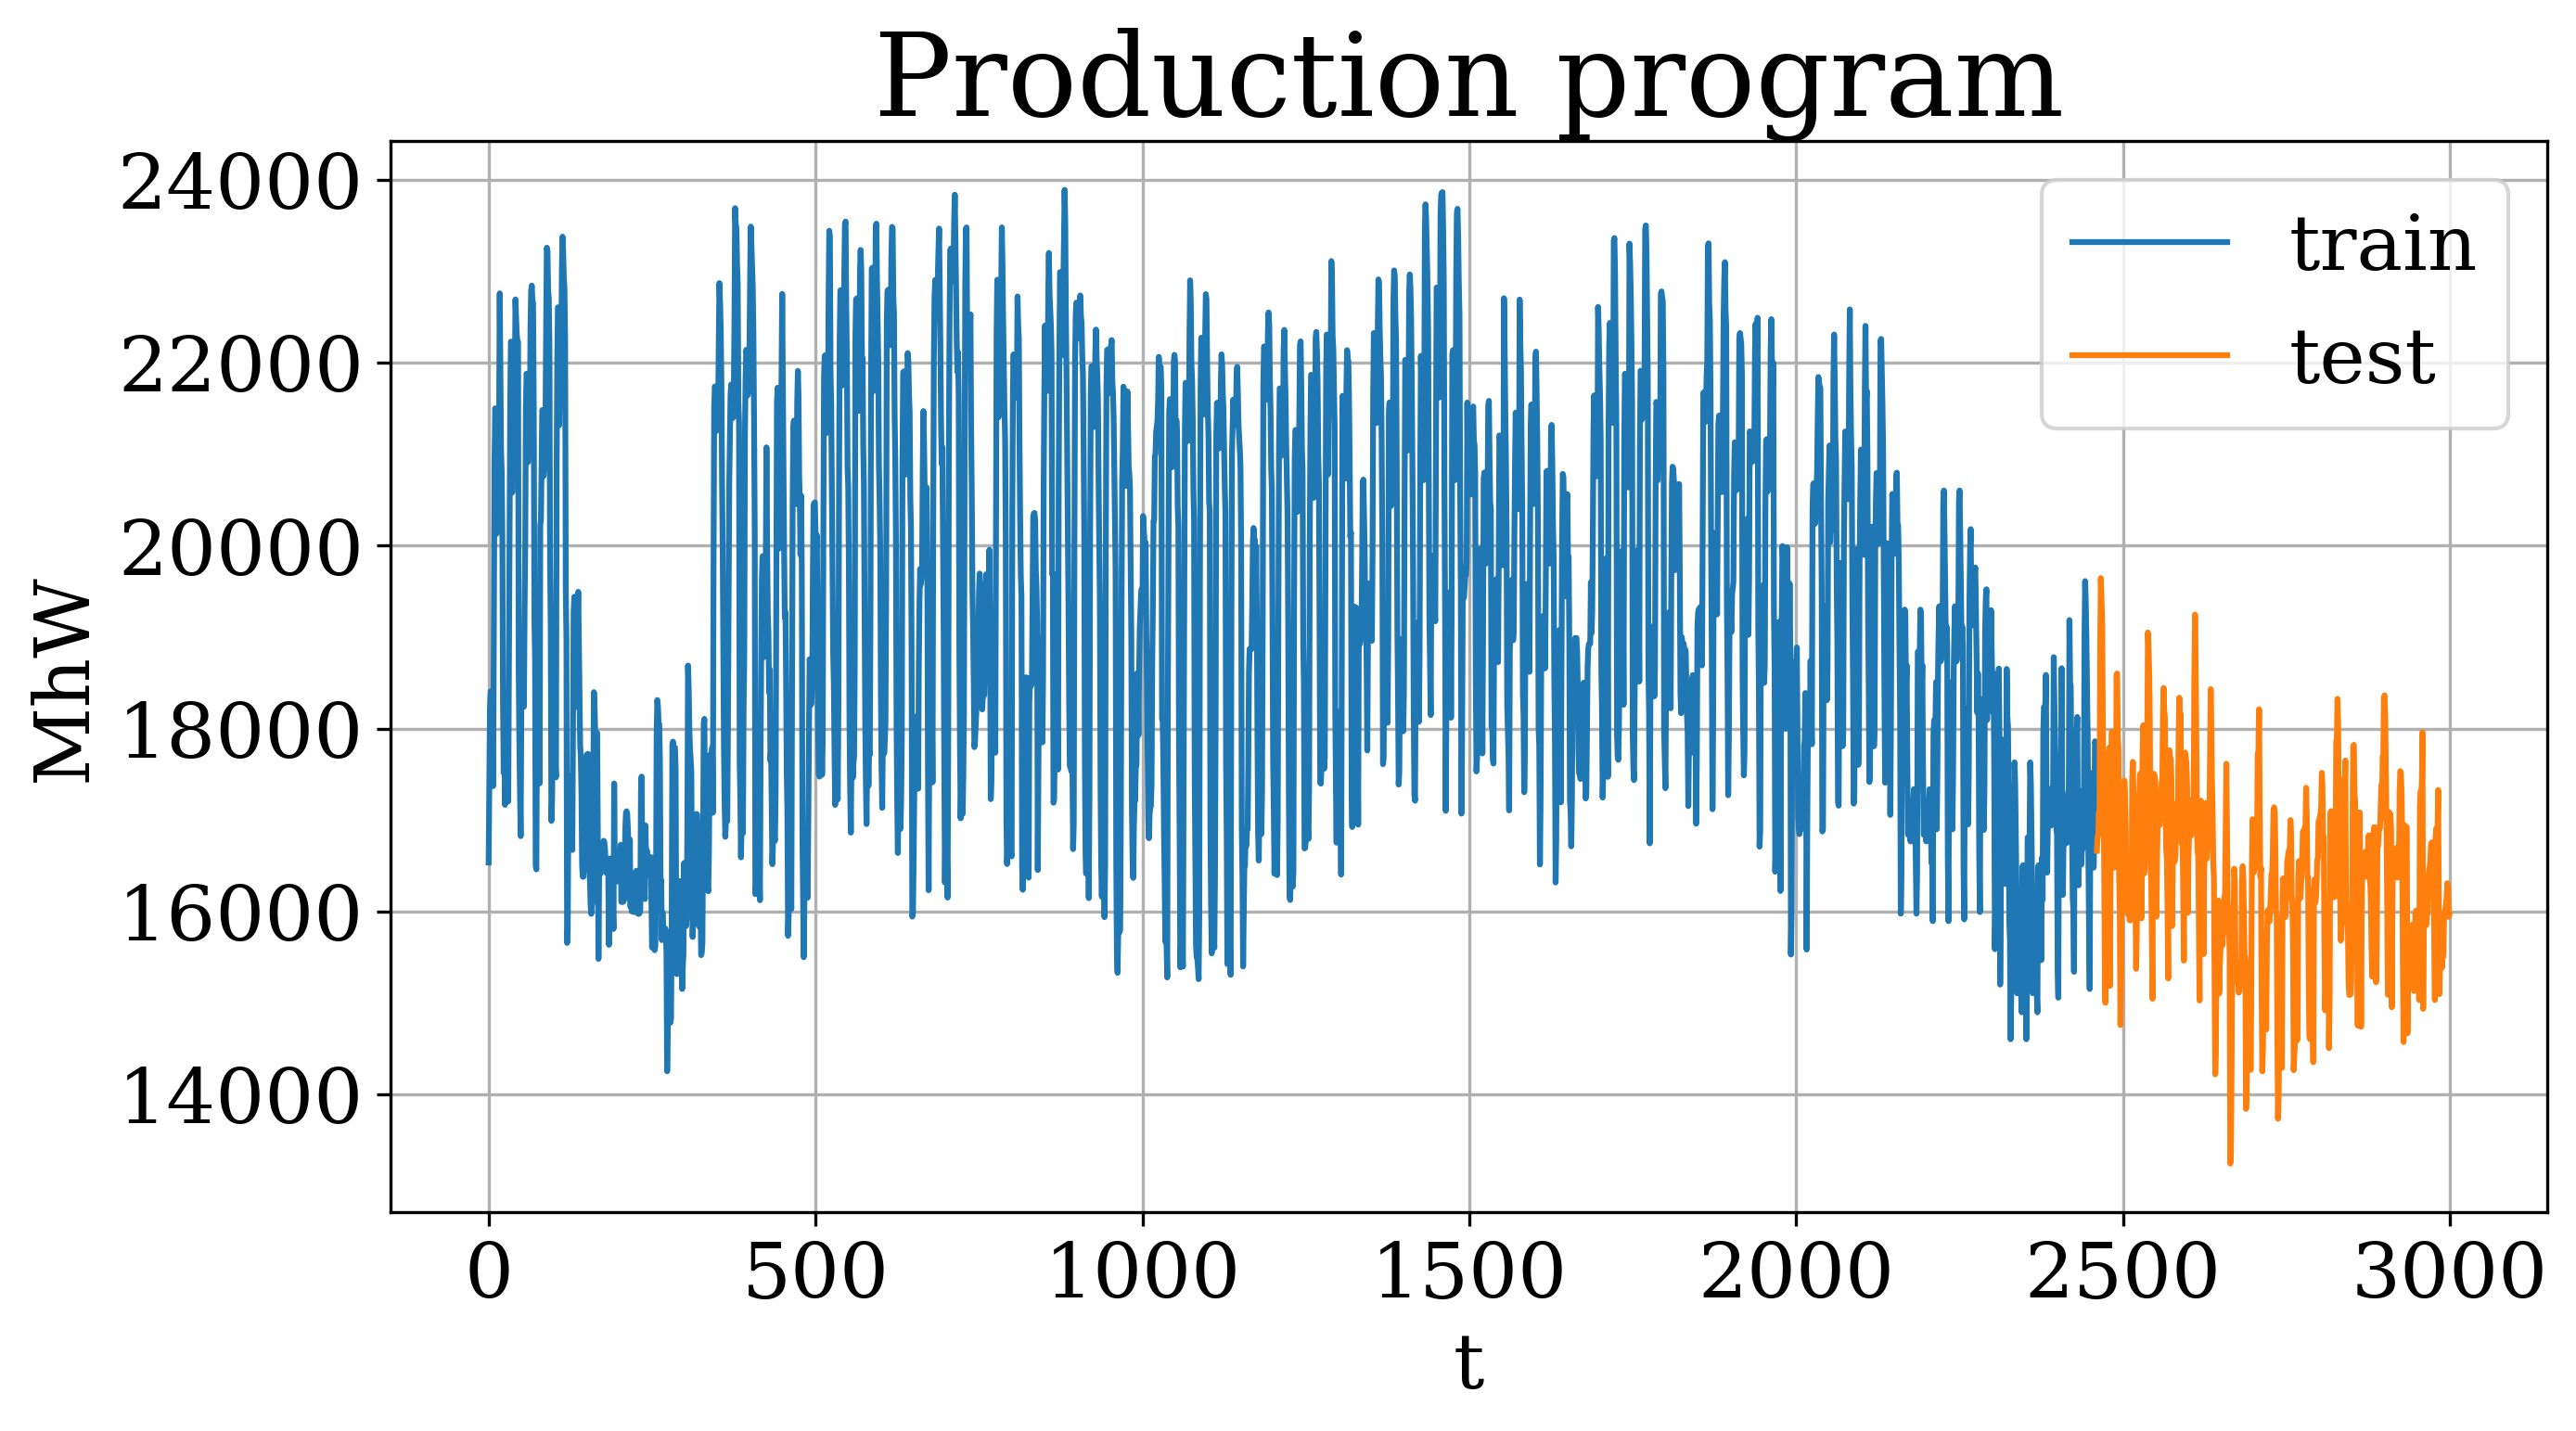

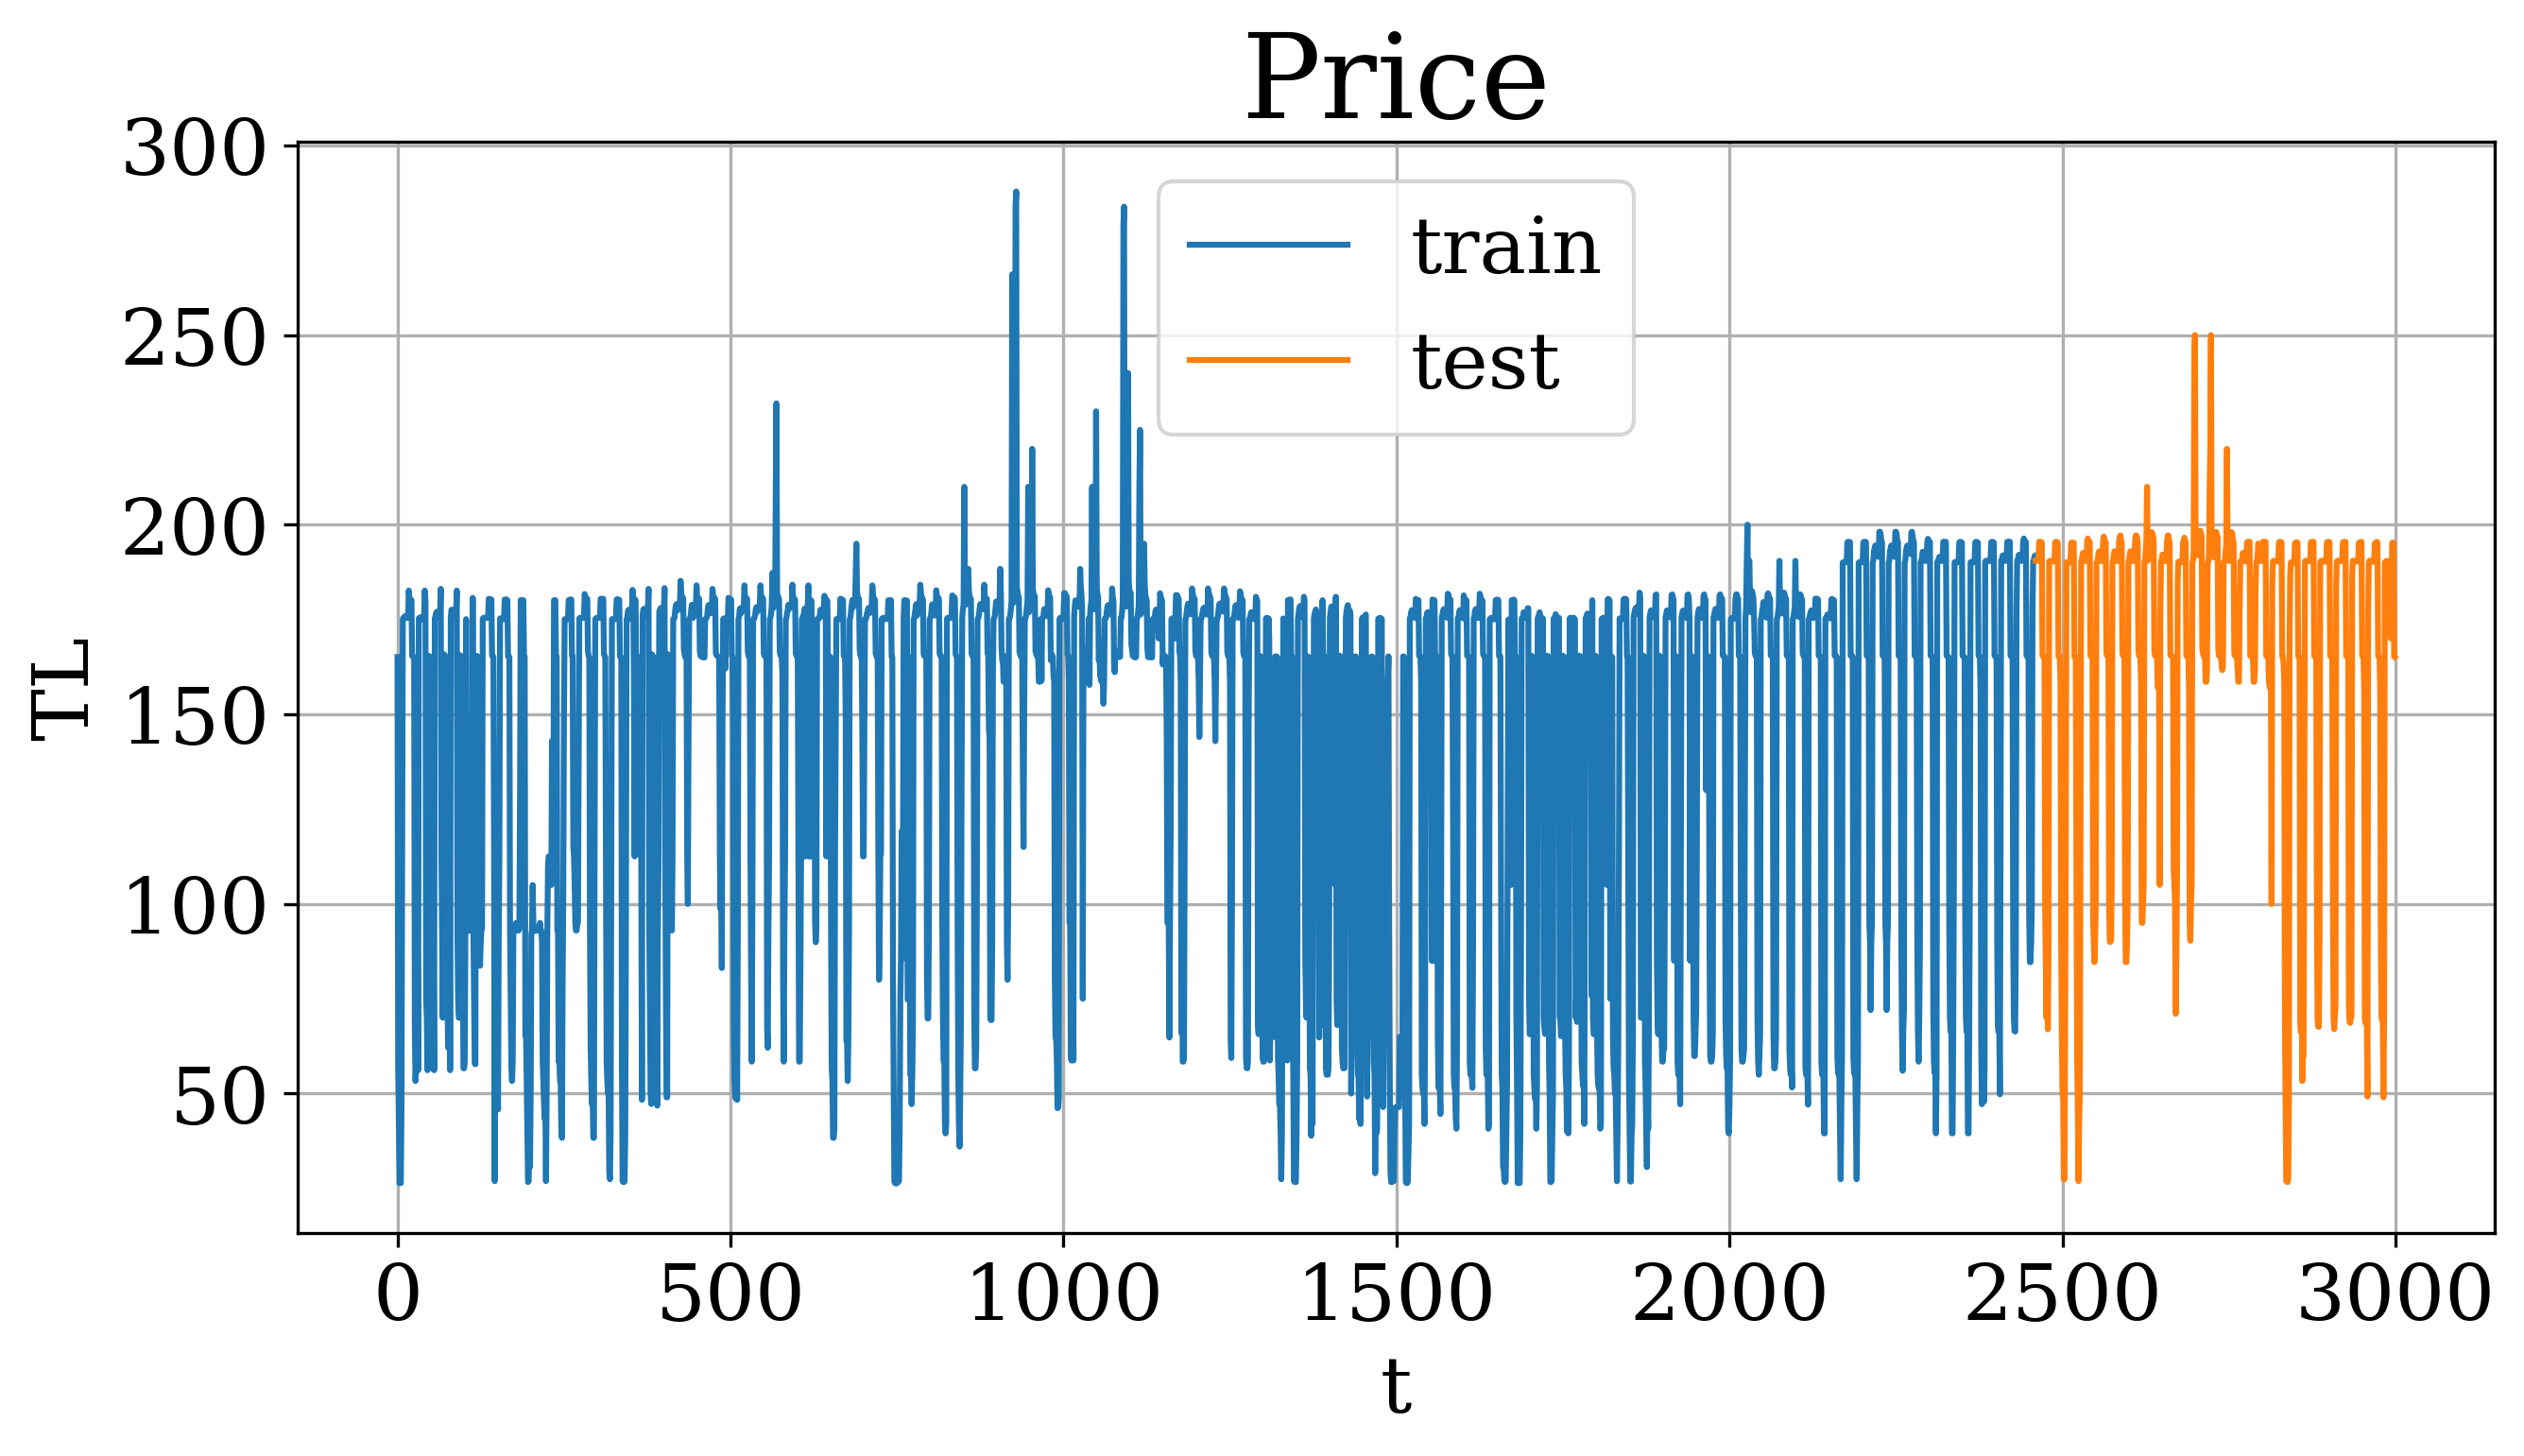

In [6]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

        if i == 0:
            fig.savefig("/home/cyrill/Sem8/Scientific_Work/figs/Electricity_Production.png", format='png')
        if i == 1:
            fig.savefig("/home/cyrill/Sem8/Scientific_Work/figs/Electricity_Price.png", format='png')

## Global method parameters

In [7]:
# aka L parameter
ssa_window_size = 500

cpd_ranks = np.arange(5, 50 + 1, 5)
forecast_results = {key: {"mse": None, "mape": None} for key in cpd_ranks}

# parameter for detereministic behaviour of tSSA
random_state = 42

In [8]:
# colours for our signals (https://colorhunt.co/palette/7f27ff9f70fdfdbf60ff8911)
color_list = ['#7F27FF', '#FF8911', '#65B741']

## tSSA fitting

In [9]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

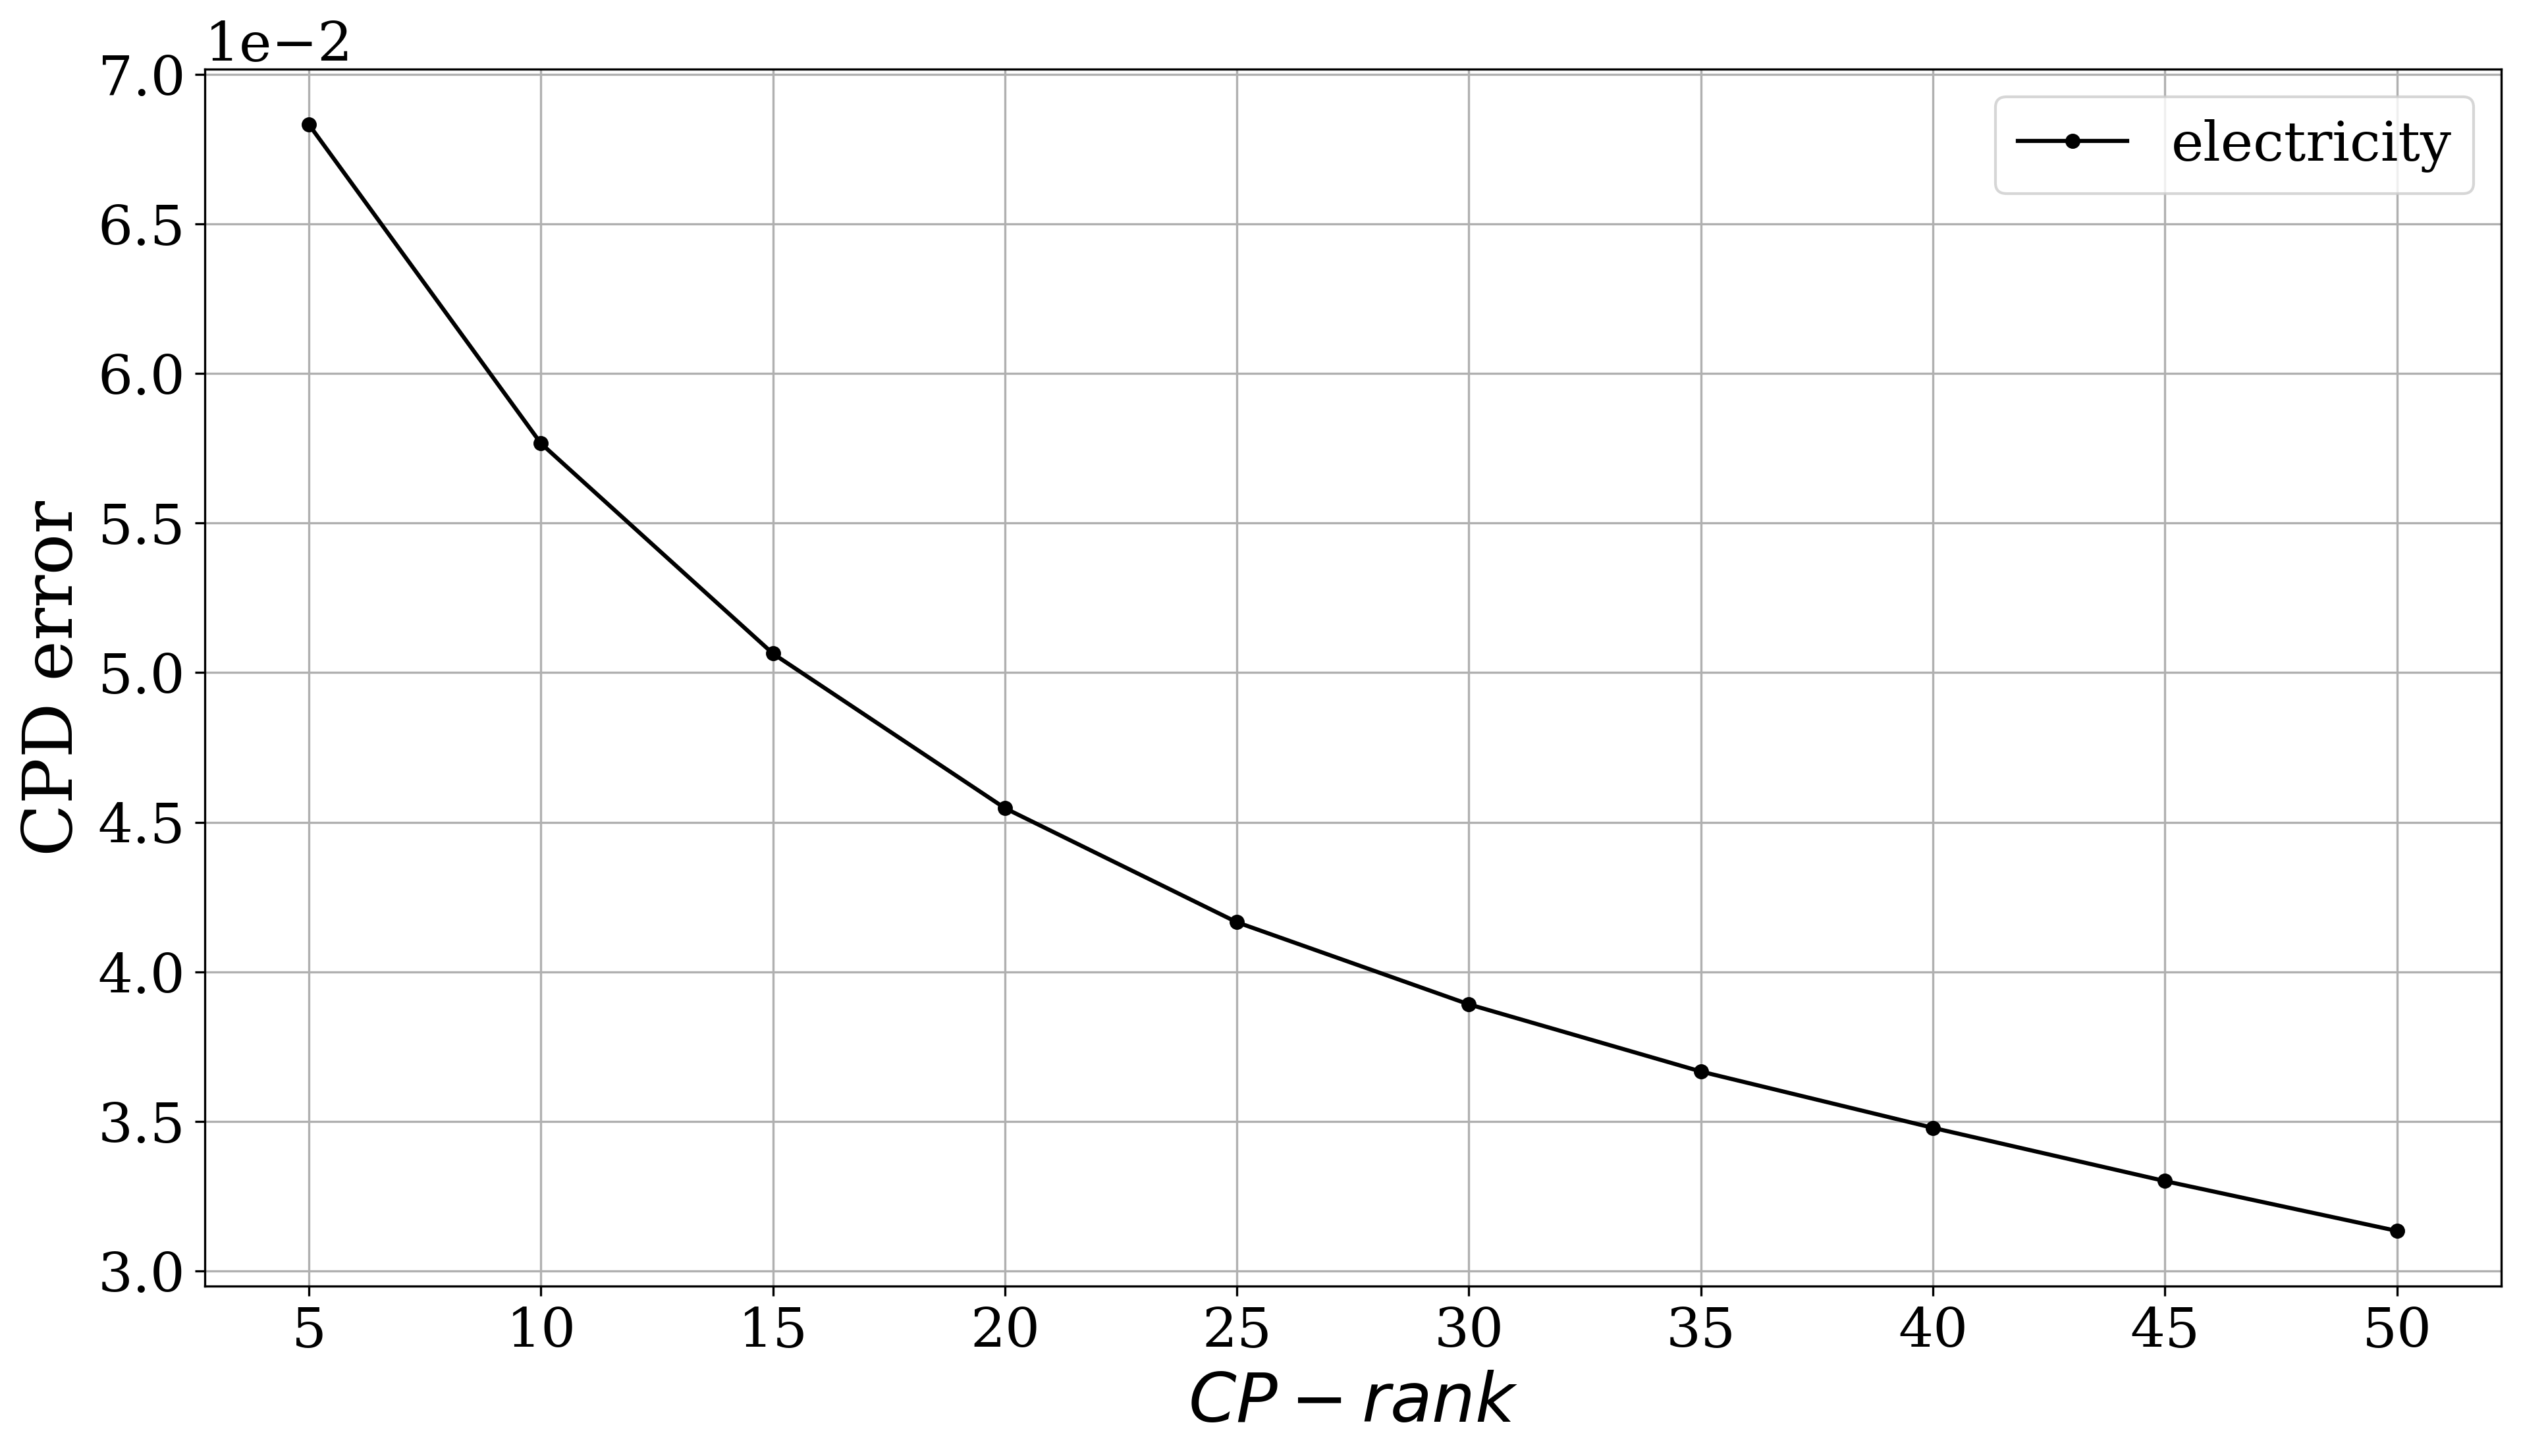

In [15]:
cpd_errors = []

for cpd_rank in cpd_ranks:
    with open(f'./saved_model/cpd_rank_{cpd_rank}.pkl', 'rb') as f:
        t_ssa_obj: t_SSA = pickle.load(f)
    
    cpd_errors.append(t_ssa_obj.cpd_err_rel)

with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(cpd_ranks, cpd_errors, marker=".", color="black", label="electricity")
    
    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"CPD error", fontsize=25)
    ax.set_xlabel('$CP-rank$', fontsize=25)

    ax.set_xticks(cpd_ranks)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    fig.savefig(f'./figs/CPD_error.png',
                         format='png')

In [10]:
for cpd_rank in cpd_ranks:
    print(f"CP rank = {cpd_rank}")

    t_ssa_obj = t_SSA(ssa_window_size, train_data.T, cpd_rank)

    # make svd for common matrix, extract factors and singular values
    t_ssa_obj.decompose_tt(random_state=random_state)
    print(f"CPD-error = {t_ssa_obj.cpd_err_rel}")

    # save model
    with open(f'./saved_model/cpd_rank_{cpd_rank}.pkl', 'wb') as f:
        pickle.dump(t_ssa_obj, f)

    t_ssa_obj.remove_last_predictions()

    # get prediction for cuurent number of factors left
    forecast_tssa = np.empty(test_data.shape)
    
    for i in range(test_data.shape[0]):
        forecast_tssa[i] = np.array(t_ssa_obj.predict_next())
    
    # get MSE for every signal
    signals_mse_tssa = np.mean((forecast_tssa - test_data) ** 2, axis=0)
    # get MAPE for every signal
    signals_mape_tssa = np.mean(np.abs((forecast_tssa - test_data) / test_data), axis=0)

    forecast_results[cpd_rank]["mse"] = signals_mse_tssa
    forecast_results[cpd_rank]["mape"] = signals_mape_tssa
    
    print(f'MSE: {signals_mse_tssa}; Mean by signals = {np.mean(signals_mse_tssa):e}')
    print(f'MAPE: {signals_mape_tssa}; Mean by signals = {np.mean(signals_mape_tssa):e}')

CP rank = 5
CPD-error = 0.06831772657595535
MSE: [957304.12507027   1164.09064563]; Mean by signals = 4.792341e+05
MAPE: [0.04762648 0.22760907]; Mean by signals = 1.376178e-01
CP rank = 10
CPD-error = 0.05766094731096005
MSE: [1.56882242e+06 1.03314127e+03]; Mean by signals = 7.849278e+05
MAPE: [0.05963761 0.17744386]; Mean by signals = 1.185407e-01
CP rank = 15
CPD-error = 0.050637000412448965
MSE: [1.62342369e+06 9.84296006e+02]; Mean by signals = 8.122040e+05
MAPE: [0.06196751 0.16515961]; Mean by signals = 1.135636e-01
CP rank = 20
CPD-error = 0.04546995707834396
MSE: [1.72195936e+06 9.68420202e+02]; Mean by signals = 8.614639e+05
MAPE: [0.06462125 0.17008434]; Mean by signals = 1.173528e-01
CP rank = 25
CPD-error = 0.041657011992926485
MSE: [1.27419945e+06 9.30323792e+02]; Mean by signals = 6.375649e+05
MAPE: [0.05472278 0.168196  ]; Mean by signals = 1.114594e-01
CP rank = 30
CPD-error = 0.0389126097223424
MSE: [1.24150821e+06 8.85919466e+02]; Mean by signals = 6.211971e+05
MAPE

In [12]:
with open(f"./saved_model/forecast_results", "wb") as f:
    pickle.dump(forecast_results, f)

In [17]:
with open(f"./saved_model/forecast_results", "rb") as f:
    forecast_results:dict = pickle.load(f)

    print(forecast_results[30])

{'mse': array([1.24150821e+06, 8.85919466e+02]), 'mape': array([0.05370686, 0.16451571])}


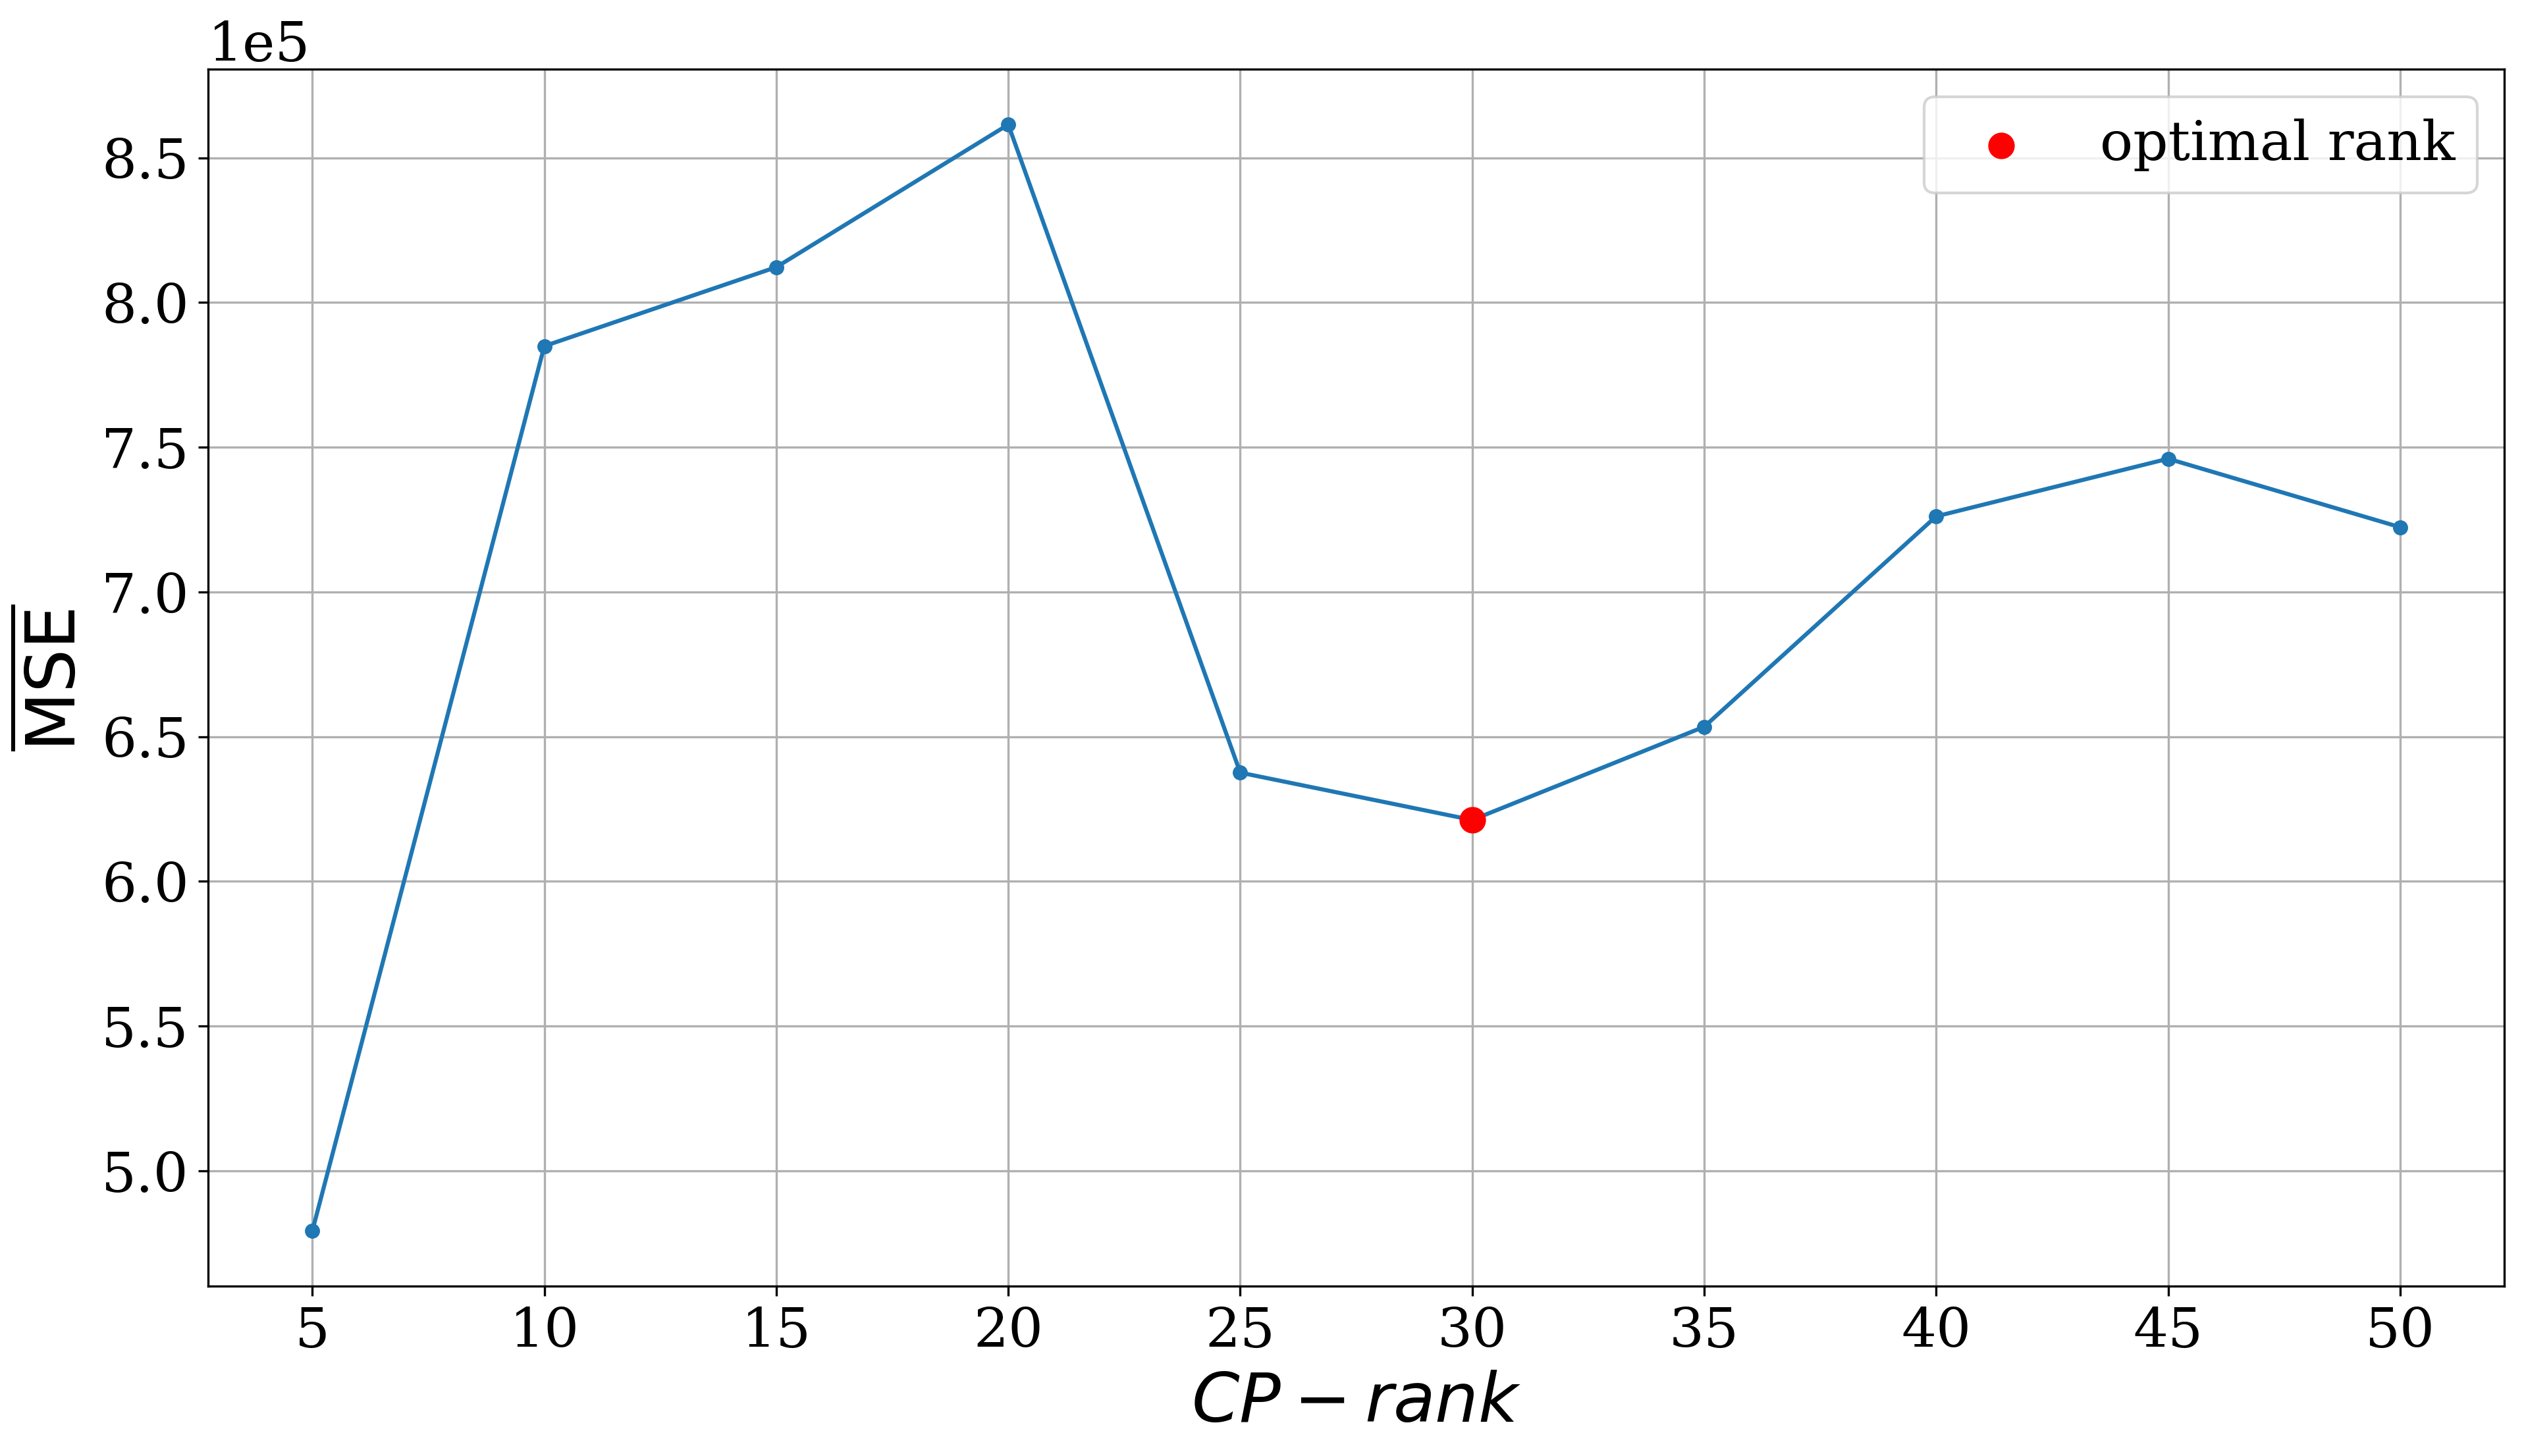

In [68]:
# plot mean MSE
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    mean_mses = []
    for key, item in forecast_results.items():
        mean_mses.append(item["mse"].mean())

    ax.plot(forecast_results.keys(), mean_mses, marker=".")
    ax.scatter([30], [mean_mses[5]], marker=".", s=300, c="red", label="optimal rank", zorder=10)
    
    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"$ \overline{\text{MSE}} $", fontsize=25)
    ax.set_xlabel('$CP-rank$', fontsize=25)

    ax.set_xticks(list(forecast_results.keys()))
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    fig.savefig(f'./figs/prediction/MSE_rank.png',
                         format='png')

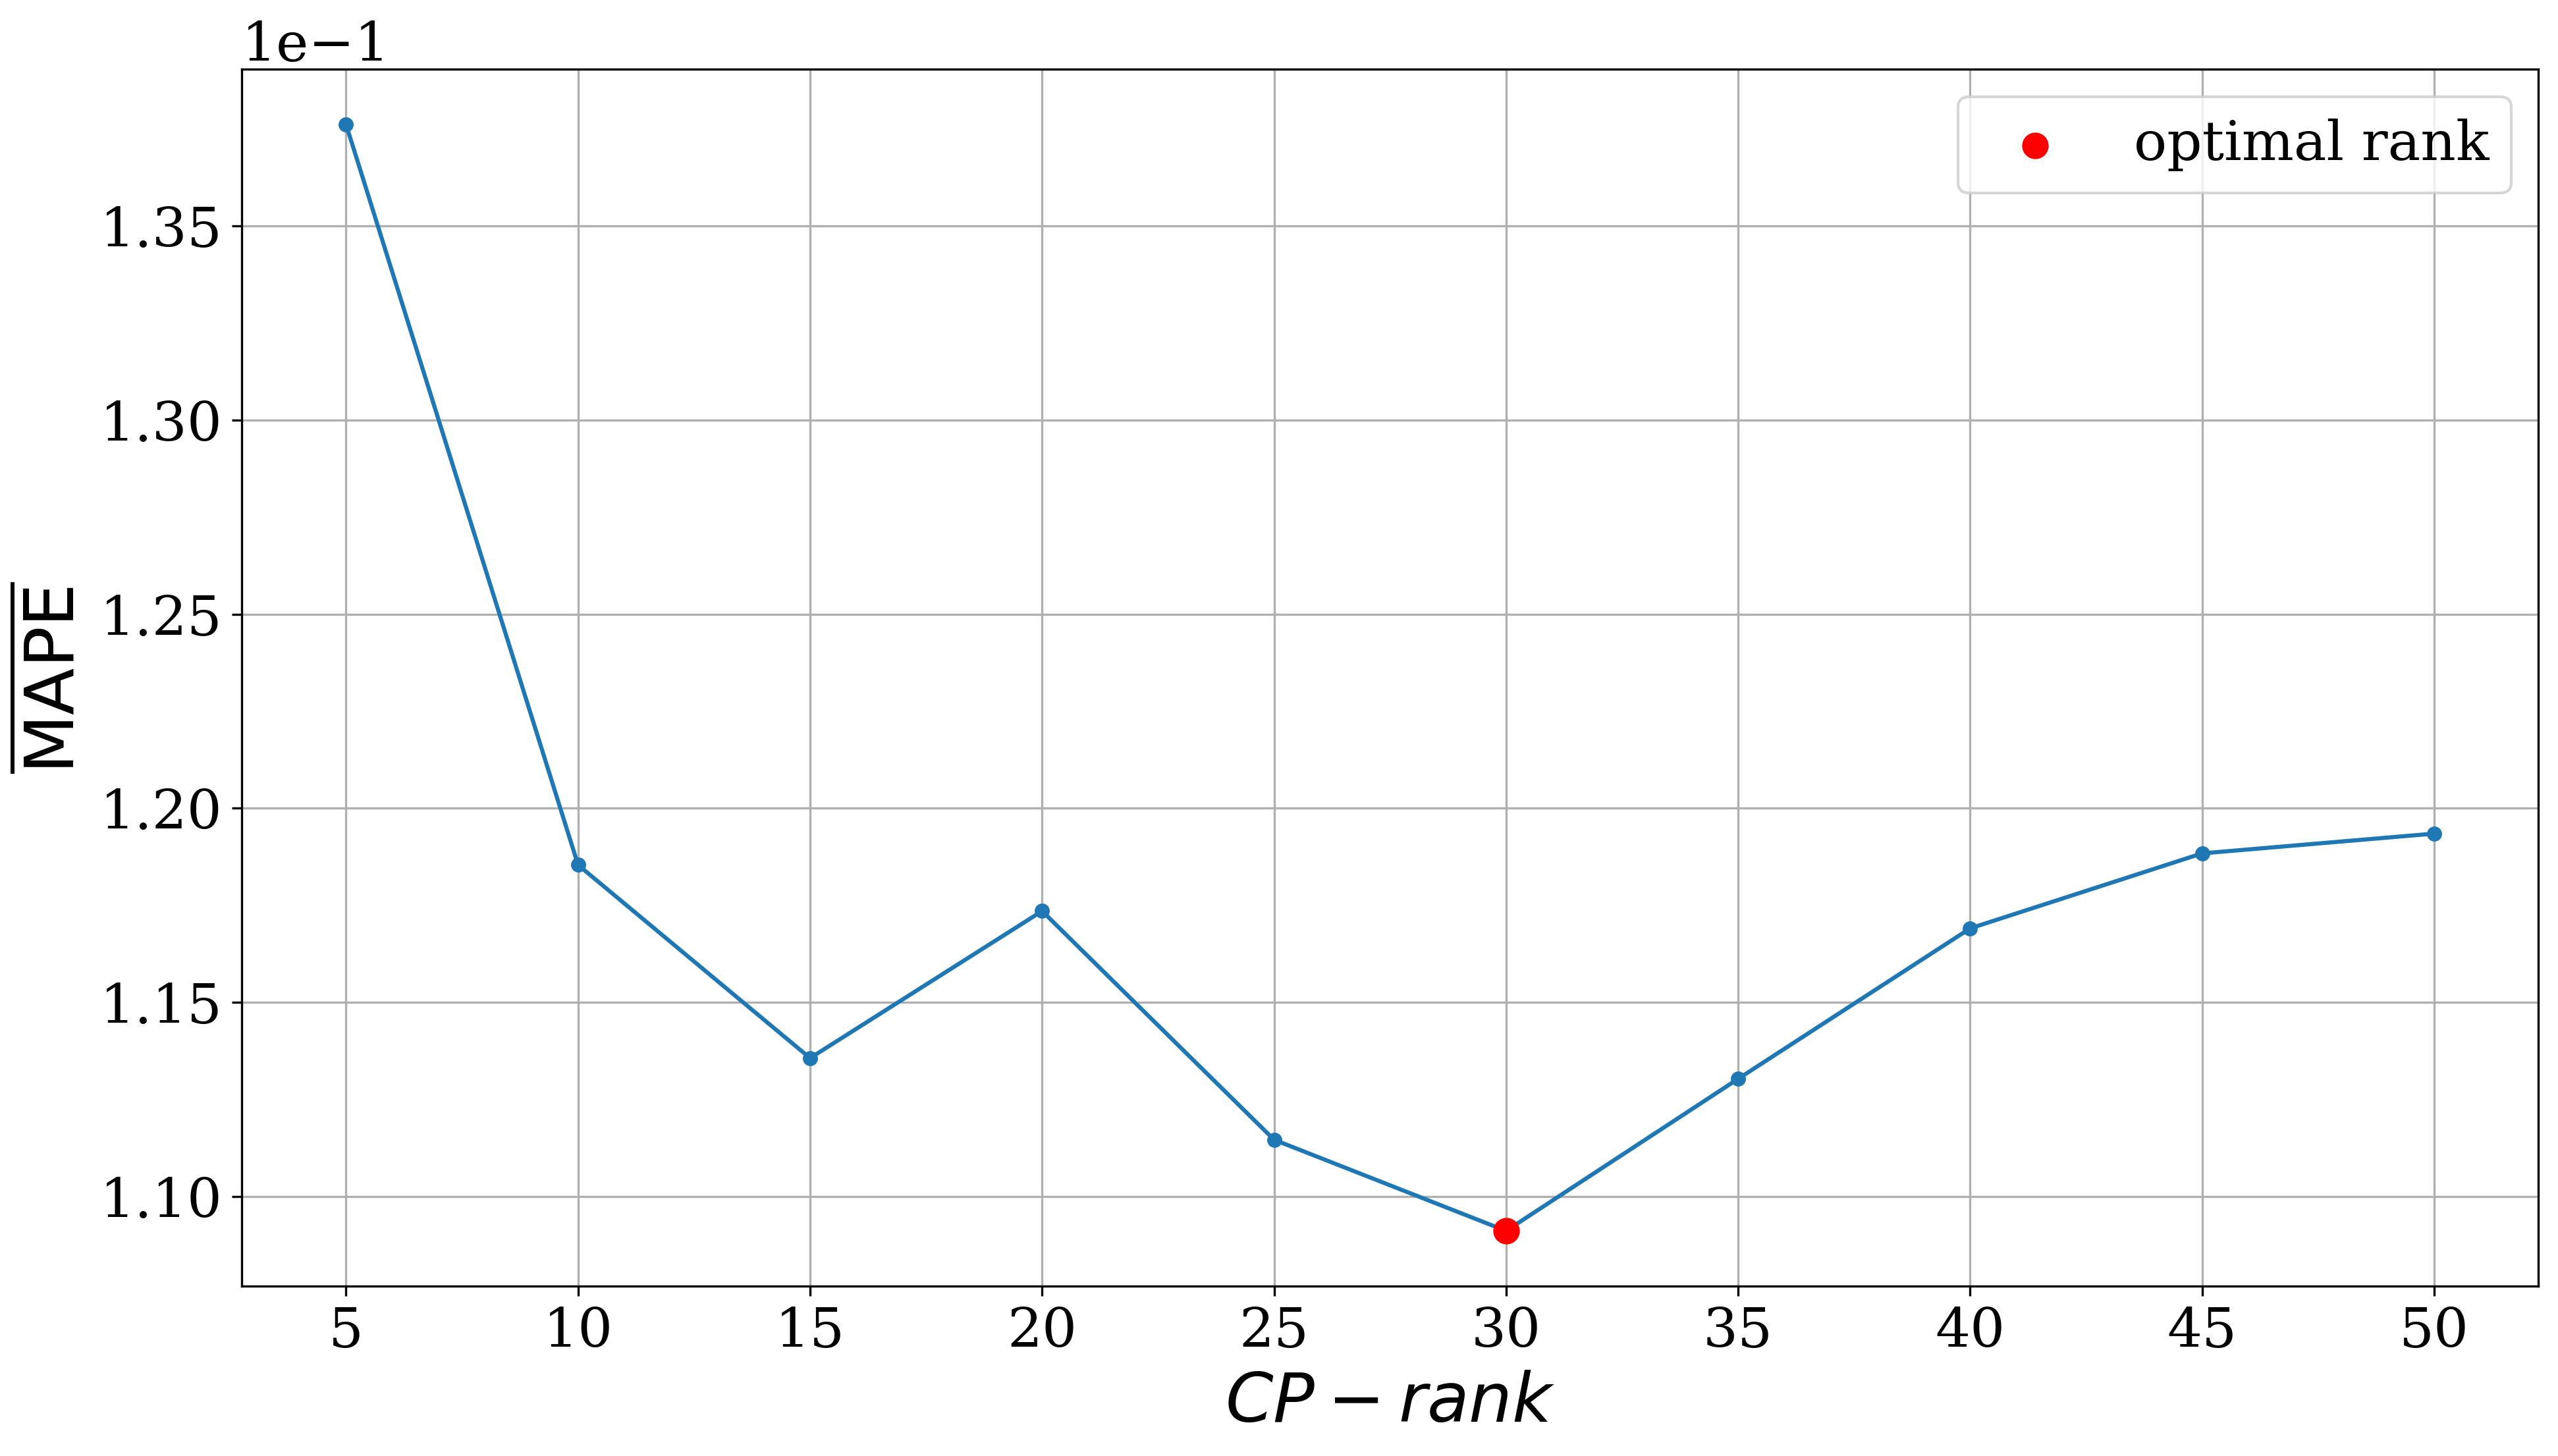

In [69]:
# plot mean MAPE
with EnableJournalStylePlotting():
    fig, ax = plt.subplots(figsize=(15, 8))

    mean_mapes = []
    for key, item in forecast_results.items():
        mean_mapes.append(item["mape"].mean())

    ax.plot(forecast_results.keys(), mean_mapes, marker=".")
    ax.scatter([30], [mean_mapes[5]], marker=".", s=300, c="red", label="optimal rank", zorder=10)

    ax.legend()
    ax.grid(True)
    ax.set_ylabel(r"$ \overline{\text{MAPE}} $", fontsize=25)
    ax.set_xlabel('$CP-rank$', fontsize=25)

    ax.set_xticks(list(forecast_results.keys()))
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))

    fig.savefig(f'./figs/prediction/MAPE_rank.png',
                         format='png')

## Prediction

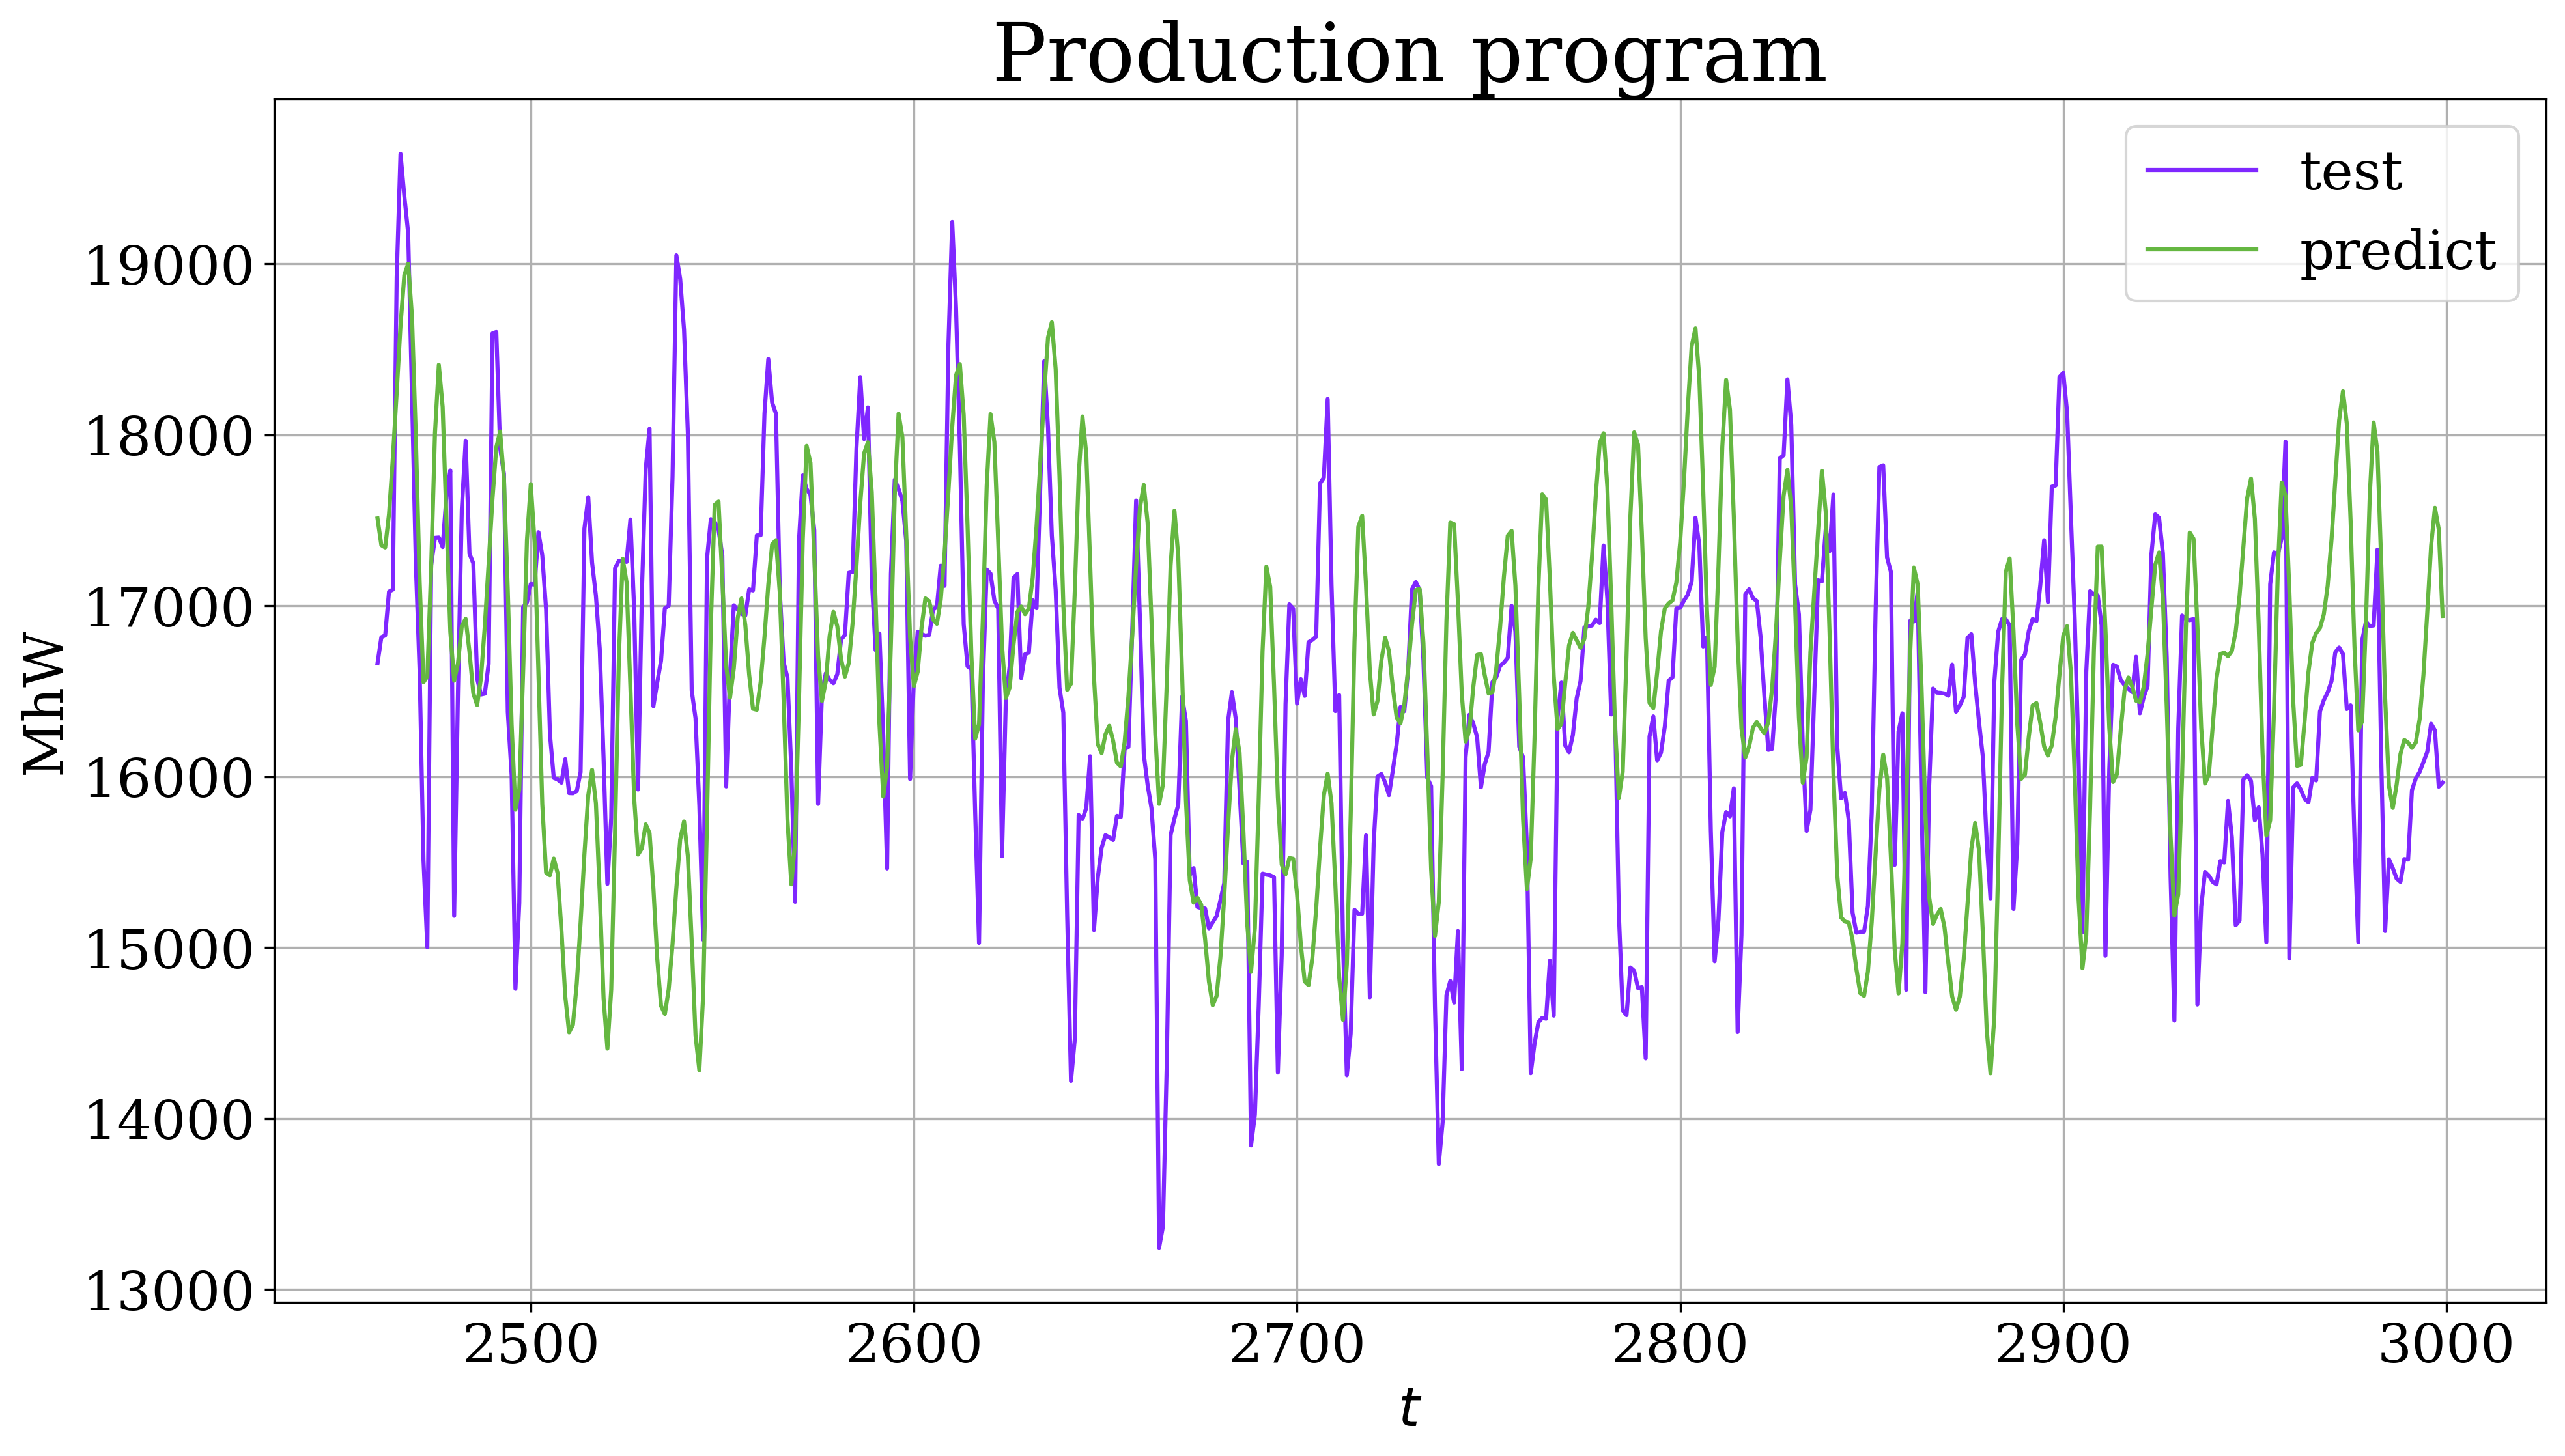

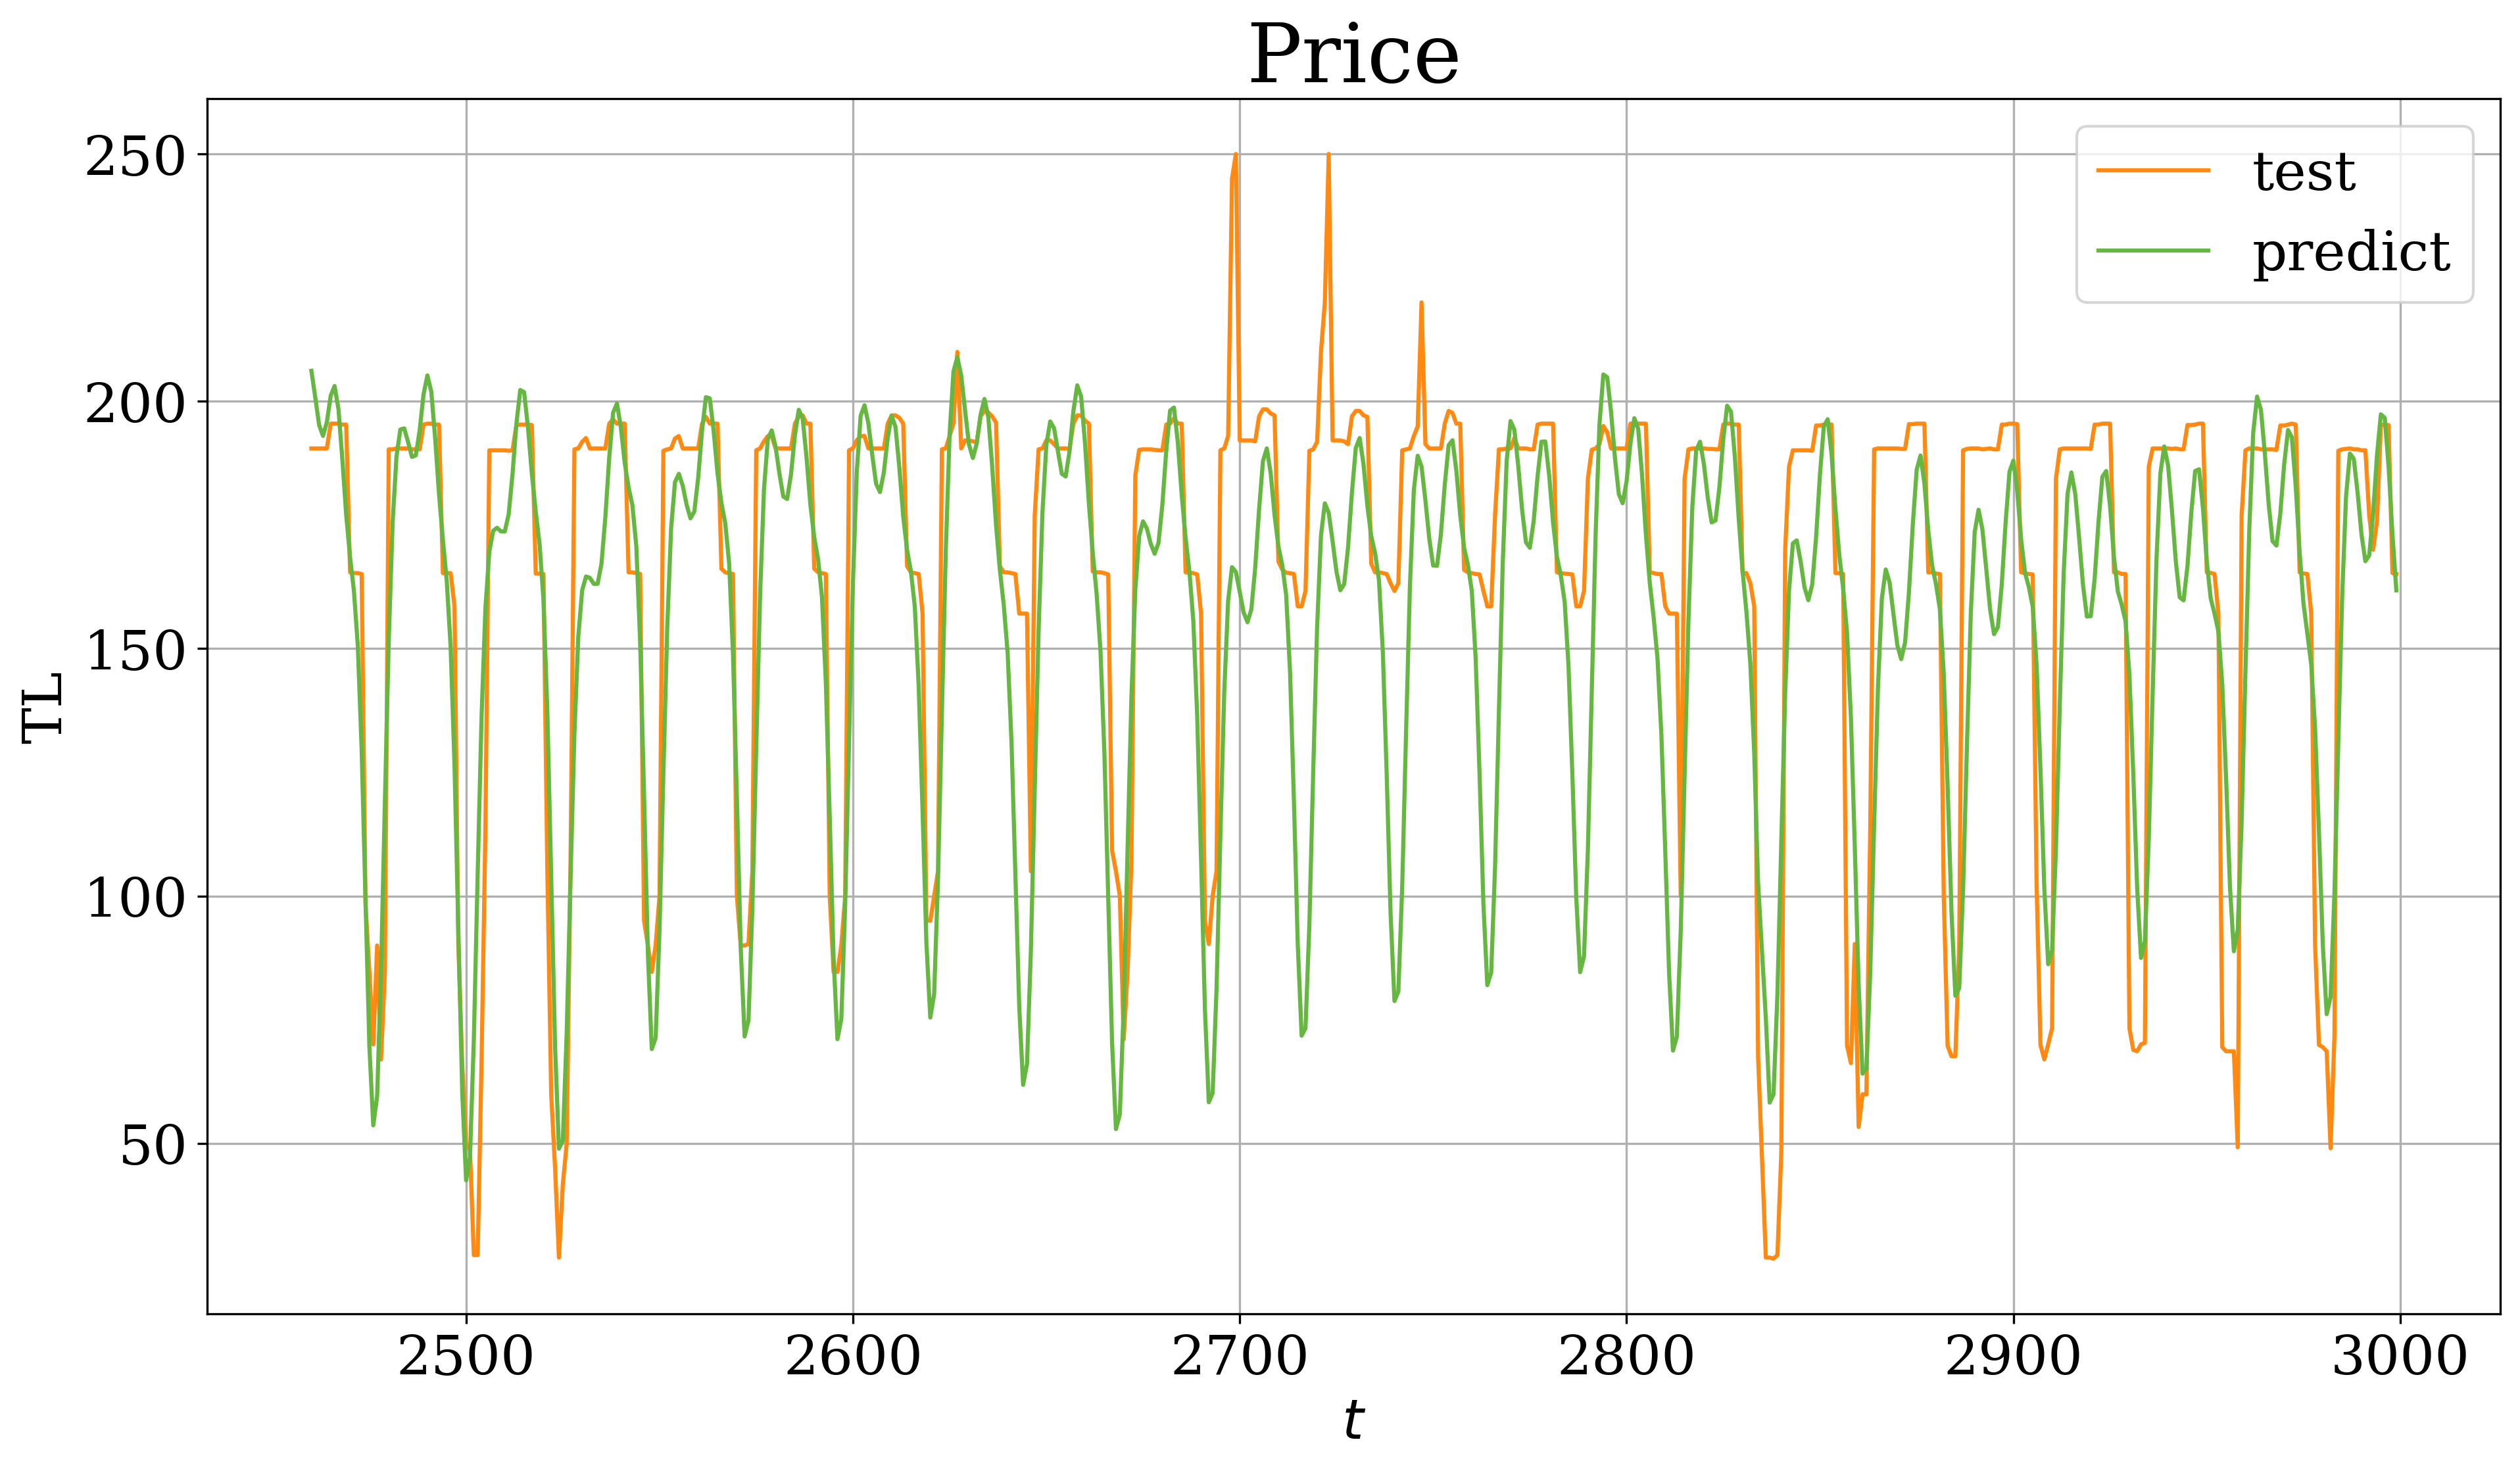

In [16]:
# make directory for figures
pathlib.Path(f'./figs/prediction/cpd_rank_30').mkdir(parents=True, exist_ok=True)

with open(f'./saved_model/cpd_rank_30.pkl', 'rb') as f:
        t_ssa_obj = pickle.load(f)

t_ssa_obj.remove_last_predictions()

# get prediction for cuurent number of factors left
forecast_tssa = np.empty(test_data.shape)

for i in range(test_data.shape[0]):
    forecast_tssa[i] = np.array(t_ssa_obj.predict_next())

for i in range(test_data.shape[1]):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(15, 8))

        ax.plot(time_grid_test, test_data.T[i], color=color_list[i], label='test')
        ax.plot(time_grid_test, forecast_tssa.T[i], color=color_list[-1], label='predict')

        ax.grid(True)
        ax.legend();
        ax.set_ylabel(f'{sig_units[i]}', fontsize=20)
        ax.set_xlabel('$t$', fontsize=20)
        ax.set_title(f'{sig_names[i]}', fontsize=30)

        fig.savefig(f'./figs/prediction/cpd_rank_30/{sig_names[i].replace(" ", "_")}.png',
                             format='png')